In [9]:
import json
import pandas as pd
import re
from googletrans import Translator
from google_trans_new import google_translator  
import time
from time import sleep
from random import uniform
import datetime
from datetime import date, timezone
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
import spacy
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import numpy as np

# 1. Image Text Analysis

## 1.1 Prepare Data

In [10]:
# Defining a function to remove accented characters in English text
def remove_accents(sentence):
    return ", ".join(simple_preprocess(str(sentence), deacc=True, max_len=100))

# Detecting non-English text using regex
def detect_lang(text):
    pat = re.compile("[^\x00-\x7F]") # matches non-English characters
    if pat.search(text):
        return 0
    else:
        return 1

In [11]:
## text in image
with open('image_text.json') as f:
  data_dict = json.load(f)

df = pd.DataFrame.from_dict(data_dict)
df = df.T
df = df.reset_index()
clean_df = df

clean_df["is_english"] = df["text"].map(detect_lang)
unique_df = clean_df.drop_duplicates(subset = ["text"])
english = unique_df[(unique_df['is_english'] ==1)]
english["english_text"] =english["text"]

In [12]:
clean_df.shape

(2415, 3)

In [13]:
non_english = pd.read_csv('non_english_jun2021.csv')

In [14]:
all_english = pd.concat([english, non_english])

## 1.2. Tokenize Data

In [7]:
#all_english.iloc[1]['english_text']

In [92]:
# from nltk.tokenize import word_tokenize
# all_text = all_english["english_text"].str.cat(sep='\n')
# tokenized_word= word_tokenize(all_text)
# print(tokenized_word)

In [133]:
# from nltk.probability import FreqDist
# fdist = FreqDist(tokenized_word)
# print(fdist)

In [134]:
# # Frequency Distribution Plot
# import matplotlib.pyplot as plt
# fdist.plot(30,cumulative=False)
# plt.show()

In [15]:
# Creating stop words list
stop_words = stopwords.words("english")

# Adding domain words 
stop_words.extend(["will","yes","#",".","_","%","|","r","sr","also","bamboo","b"])

In [7]:
# nlp = spacy.load('en_core_web_sm')
# doc = nlp("Little update Any blood group will do as we would be")
# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#         token.shape_, token.is_alpha, token.is_stop)

In [16]:
nlp = spacy.load('en_core_web_sm')
allowed_posttags=["NOUN", "PROPN", "VERB", "ADJ", "ADV"]
lemmatized_tokens = []
for text in all_english["english_text"]:
    #print(text)
    doc = nlp(text)
    for token in doc:
        if(token.pos_ in allowed_posttags):
            lemmatized_tokens.append(token.lemma_)
        #print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        #    token.shape_, token.is_alpha, token.is_stop)

In [17]:
lemmatized_tokens_lower = map(str.lower, lemmatized_tokens)

In [18]:
lemmatized_tokens_stopped = [token for token in lemmatized_tokens_lower if token not in stop_words]

In [19]:
from nltk.probability import FreqDist
fdist = FreqDist(lemmatized_tokens_stopped)
print(fdist)

<FreqDist with 25120 samples and 133357 outcomes>


In [20]:
top_fifty = fdist.most_common(50)

In [21]:
print(top_fifty)

[('hospital', 1350), ('blood', 1205), ('available', 1130), ('patient', 1049), ('oxygen', 937), ('name', 740), ('covid', 709), ('report', 670), ('pm', 584), ('contact', 539), ('day', 520), ('medical', 486), ('number', 474), ('may', 474), ('plasma', 471), ('india', 465), ('district', 456), ('date', 452), ('help', 440), ('time', 439), ('donor', 428), ('health', 412), ('delhi', 406), ('covid-19', 383), ('group', 374), ('bed', 374), ('nashik', 373), ('need', 354), ('home', 348), ('center', 339), ('state', 330), ('give', 323), ('dr.', 317), ('free', 315), ('use', 314), ('age', 307), ('take', 305), ('e', 291), ('new', 279), ('government', 277), ('injection', 276), ('aligarh', 268), ('mg', 268), ('call', 266), ('corona', 260), ('make', 258), ('road', 244), ('hyderabad', 243), ('bank', 241), ('kumar', 240)]


In [22]:
fdist.get('hospital')

1350

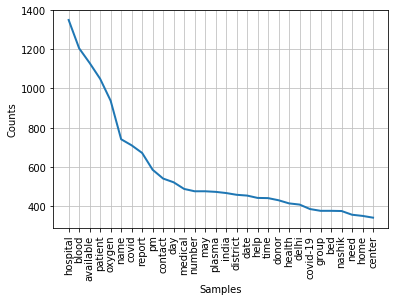

In [23]:
# Frequency Distribution Plot
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [24]:
image_word_freq = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])
image_total_words = sum(image_word_freq['frequency']) #len(WA_word_freq)
image_word_freq['img_proportion'] = image_word_freq['frequency']/image_total_words

In [25]:
image_word_freq

,word,frequency,img_proportion
0,little,18,0.000135
1,update,53,0.000397
2,blood,1205,0.009036
3,group,374,0.002805
4,would,66,0.000495
...,...,...,...
25115,paeumothena,1,0.000007
25116,sav,1,0.000007
25117,tabel,1,0.000007
25118,govnd,1,0.000007


In [26]:
all_english.columns

Index(['index', 'text', 'is_english', 'english_text', 'Unnamed: 0'], dtype='object')

In [71]:
verified_resource_list = pd.read_csv('factchecker_covid_list.csv')
phonelist = verified_resource_list['phone_1'].append(verified_resource_list['phone_2'])
phonelist.dropna(inplace=True) 
for phone in phonelist:
    check = all_english[all_english['text'].str.contains(phone)]
    if not check.empty:
        print(phone)
        print(check['text'])

# 2. Analysis of WhatsApp Conversations

## 2.1 Prepare Data

In [29]:
WA_text = pd.read_csv('2021July13_whatsapptext_all_english.csv')
WA_text = WA_text[WA_text['has_media'] == False]

excluded_groups = ['1d80c681c6bd089ed87f5621b2b5a5c1b863e978cf3bc1bceddfe3634e9713c5',
                  '3b7ab2f5937776fc15436c4aa8c7ce4a5794d04dcc7abd634a26b23a43baed90',
                  '53256805e4ca4bc13d0f6b0def75afa1ea2f85be25015d123b20faab3506503a',
                  '334f40dd68492c94847832d40b67b59f675dc3da577ed548390c3511f6459f67',
                  '6ddab15f6695c440c164230b4d1aacff195423fc3759191bf4179c990a617c45',
                  '88f77040e70941006eff31f4297352cf7b1453e3a2b15a9c7c25f590a2a90354']
WA_text = WA_text[~WA_text['group_id'].isin(excluded_groups)]
WA_text = WA_text[WA_text['datetime']>'2021-05-06']
WA_text = WA_text[WA_text['datetime']<'2021-06-25']

In [30]:
WA_text.shape

(13524, 13)

## 2.2 Tokenize Data

In [33]:
nlp = spacy.load('en_core_web_sm')
allowed_posttags=["NOUN", "PROPN", "VERB", "ADJ", "ADV"]
WA_lemmatized_tokens = []
for text in WA_text["english_content"]:
    if text != text: #exclude string from tokenization if NAN
            continue
    doc = nlp(text)
    for token in doc:
        if(token.pos_ in allowed_posttags):
            WA_lemmatized_tokens.append(token.lemma_)
        #print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        #    token.shape_, token.is_alpha, token.is_stop)

In [34]:
WA_lemmatized_tokens_lower = map(str.lower, WA_lemmatized_tokens)
WA_lemmatized_tokens_stopped = [token for token in WA_lemmatized_tokens_lower if token not in stop_words]

In [35]:
from nltk.probability import FreqDist
WA_fdist = FreqDist(WA_lemmatized_tokens_stopped)
print(WA_fdist)

<FreqDist with 19530 samples and 155683 outcomes>


In [36]:
WA_top_fifty = WA_fdist.most_common(50)
print(WA_top_fifty)

[('hospital', 2355), ('patient', 1563), ('oxygen', 1447), ('need', 1274), ('blood', 1269), ('contact', 1189), ('help', 1145), ('name', 1144), ('group', 1142), ('available', 978), ('🙏', 978), ('covid', 935), ('bed', 881), ('delhi', 844), ('verify', 751), ('may', 728), ('plasma', 714), ('lead', 699), ('thank', 688), ('number', 639), ('jaipur', 615), ('require', 578), ('age', 537), ('day', 524), ('time', 464), ('hai', 444), ('take', 416), ('case', 413), ('call', 412), ('icu', 409), ('share', 402), ('give', 402), ('urgent', 392), ('send', 390), ('try', 387), ('free', 377), ('unit', 374), ('donor', 369), ('people', 369), ('ventilator', 361), ('location', 359), ('date', 357), ('requirement', 352), ('india', 350), ('healing', 350), ('injection', 342), ('pm', 334), ('new', 325), ('get', 322), ('join', 321)]


In [37]:
WA_word_freq=pd.DataFrame(WA_fdist.items(), columns=['word', 'frequency'])

In [53]:
# # Frequency Distribution Plot
# import matplotlib.pyplot as plt
# WA_fdist.plot(30,cumulative=False)
# plt.show()

In [38]:
WA_total_words = sum(WA_word_freq['frequency']) #len(WA_word_freq)

In [39]:
WA_word_freq['WA_proportion'] = WA_word_freq['frequency']/WA_total_words

In [40]:
WA_word_freq.head(2)

,word,frequency,WA_proportion
0,patient,1563,0.010040
1,atul,7,0.000045


# 3. Compare Image and Text Data

In [41]:
result = pd.merge(WA_word_freq, image_word_freq, how="outer", on=["word"])

In [ ]:
# result_inner = pd.merge(WA_word_freq, image_word_freq, how="outer", on=["word"])
# result['WA_proportion'] = result['frequency_x']/76862
# result['img_proportion'] = result['frequency_y']/102893
# print(sum(result['frequency_y']))
# print(sum(WA_word_freq['frequency']))

In [42]:
result.head(2)

,word,frequency_x,WA_proportion,frequency_y,img_proportion
0,patient,1563.0,0.010040,1049.0,0.007866
1,atul,7.0,0.000045,12.0,0.000090


In [43]:
result['prop_diff'] = abs(result["WA_proportion"] - result["img_proportion"])

In [65]:
temp = result[["WA_proportion","img_proportion"]]
temp.corr(method='pearson')#, min_periods=1)

,WA_proportion,img_proportion
WA_proportion,1.000000,0.846086
img_proportion,0.846086,1.000000


In [66]:
result_clean = result[result.WA_proportion.notnull()]
result_clean = result_clean[result_clean.img_proportion.notnull()]


In [67]:
result_clean =result_clean[(result_clean['WA_proportion'] > 0.0004) & (result_clean['img_proportion'] > 0.0004)]

In [68]:
result_clean.shape

(252, 6)

In [158]:
result_clean.to_csv('check_Words.csv')

In [69]:
top = fdist.most_common(30)

WA_top = WA_fdist.most_common(30)


WA_top_df = pd.DataFrame(WA_top, columns=['word', 'frequency'])
top_df = pd.DataFrame(top, columns=['word', 'frequency'])
wordlist = WA_top_df['word'].append(top_df['word'])
result_clean = result_clean[result_clean['word'].isin(wordlist)]

In [70]:
result_clean.shape

(39, 6)

# 4. Plot Graphs


In [105]:
# import plotly.express as px
# import plotly.graph_objects as go

# fig1 = px.scatter(result_clean, x="WA_proportion", y="img_proportion", text="word", size_max=60, 
#                  #trendline="ols",
#                  log_x=True, log_y=True)


# fig1.update_traces(textposition='top center')

# fig1.update_layout(
#     #height=800,
#     #plot_bgcolor="white",
#     title_text='Comparison of Words Found in Text Messages and Images'
   
# )

# fig1.update_yaxes(range=list([-3.3880341096413864, -1.6965818195541233]))
# fig1.update_xaxes(range=list([-3.3880341096413864, -1.6965818195541233]))


# ax_arr = np.arange(0, 1.0375284158) #list(range(-3.3880341096413864, -1.6965818195541233))
# fig2 = px.line(x=ax_arr,y=ax_arr,log_x=True,log_y=True,) #, color=rgb(140, 140, 140))      
# #fig2.update_layout(plot_bgcolor="white")
               


# fig = go.Figure(data=fig1.data + fig2.data)

# fig.update_xaxes(type="log", range=list([-3.3880341096413864, -1.6965818195541233])) 
# fig.update_yaxes(type="log", range=list([-3.3880341096413864, -1.6965818195541233]))

# fig.update_layout(
#     #plot_bgcolor="white",
#     autosize=False,
#     width=900,
#     height=900
# )

# fig.show()

In [64]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=result_clean["WA_proportion"], y=result_clean["img_proportion"],
              mode="markers+text",text=result_clean["word"],
              textposition='bottom left',
              marker=dict(
                    color='#514E80',
                    size=5,
                    opacity=0.5,),
              name = "",
              )
              
)

ax_arr = np.arange(0, 1.0375284158)
fig.add_trace(go.Scatter(
        x=ax_arr,
        y=ax_arr,
        mode="lines",
        line=dict(color="#c2c2d6", 
                 dash='dot'),
        name="y=x")
        
)


fig.update_xaxes(type="log", range=[-3.155, -1.6965818195541233],
                 showgrid=True,linecolor='black',gridcolor='#EDC9C4')
fig.update_yaxes(type="log", range=[-3.155, -1.6965818195541233],
                 showgrid=True,linecolor='black',gridcolor='#EDC9C4')



fig.update_layout(
    plot_bgcolor="white",
    autosize=False,
    width=900,
    height=900,
    yaxis=dict(tickformat=".3%"),
    xaxis=dict(tickformat=".3%",tickangle=45),
    xaxis_title="Words in Text Messages",
    yaxis_title="Words in Images"
)

fig.show()

In [250]:
# fig = px.scatter(result_clean, x="WA_proportion", y="img_proportion", text="word", size_max=60, 
#                  trendline="ols",
#                  log_x=True, log_y=True)


# fig.update_traces(textposition='top center')

# fig.update_layout(
#     #height=800,
#     #plot_bgcolor="white",
#     title_text='Comparison of Words Found in Text Messages and Images'
   
# )

full_fig = fig.full_figure_for_development()
print(full_fig.layout.xaxis.range)
print(full_fig.layout.yaxis.range)

(-3.5, -1.6965818195541233)
(-3.5, -1.6965818195541233)


0.614482103115227
0.6144819326148592 4.099461467289302e-05


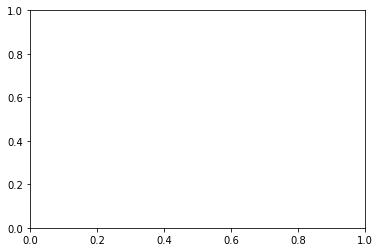

In [89]:
x = result_clean["WA_proportion"]
y = result_clean["img_proportion"]


# sdx = np.std(x)
# sdy = np.std(y)

# beta = (sdy/sdx)*0.820648
# print(beta)


## Plot Abline
axes = plt.gca()
# Find the slope and intercept of the best fit line
slope, intercept = np.polyfit(x, y, 1)

print(slope,intercept)

In [2]:
# x = result_clean["WA_proportion"]
# y = result_clean["img_proportion"]
# fig = plt.figure(figsize=(12, 12))

# # Plot the best fit line over the actual values
# plt.scatter(x="WA_proportion", y="img_proportion", data=result_clean)
# plt.xlim([0, 0.018])
# plt.ylim(0, 0.018)


# ## Plot Abline
# axes = plt.gca()
# # Find the slope and intercept of the best fit line
# slope, intercept = np.polyfit(x, y, 1)
# print(slope,intercept)

# # Create a list of values in the best fit line
# abline_values = [slope * i + intercept for i in x]

# plt.plot(x, abline_values, '--', color="gray")

# plt.xlabel("Proportion of word in text Messages")
# plt.ylabel("Proportion of word in Images")


In [1]:
# import seaborn as sns
# fig = plt.figure(figsize=(12, 12))

# sns.set_theme(style="white")

# cmap =  sns.cubehelix_palette(as_cmap=True)

# splt = sns.scatterplot(x="WA_proportion", y="img_proportion", data=result_clean, 
#                 #hue='prop_diff', 
#                 sizes=(40, 400), alpha=.5, palette="muted",
#                 cmap=cmap)

# splt.set(ylim=(0, 0.018))
# splt.set(xlim=(0, 0.018))